# Data Cleaning

In [3]:
!pip install openpyxl
!pip install pingouin
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
plt.style.use('ggplot')

# Preprocesado y análisis
# ==============================================================================
import statsmodels.api as sm
import pingouin as pg
from scipy import stats
from scipy.stats import pearsonr

from google.colab import data_table
data_table.enable_dataframe_formatter()
template_style = "plotly_dark"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.6 MB/s eta 0:00:00


In [4]:
df = pd.read_excel('basededatos.xlsx')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278649 entries, 0 to 278648
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Fecha                        278649 non-null  datetime64[ns]
 1   apat                         278466 non-null  object        
 2   amat                         271958 non-null  object        
 3   nombre                       278633 non-null  object        
 4   tiempo_espera_triage         278579 non-null  float64       
 5   tiempo_en_triage             278579 non-null  float64       
 6   tiempo_espera_despuestriage  277192 non-null  float64       
 7   tiempo_en_consulta           277180 non-null  float64       
 8   clasificacion                278649 non-null  object        
 9   edad                         278649 non-null  int64         
 10  Edad1                        278649 non-null  object        
 11  Dx                        

##### Remove duplicates and null values  

In [56]:
df_without_duplicates = df.drop_duplicates()
df_without_duplicates_and_na = df_without_duplicates.dropna()

print(f"Number of duplicates:\t\t {len(df) - len(df_without_duplicates)} - {(len(df) - len(df_without_duplicates)) / len(df) * 100:.1f}%")
print(f"Number of missing values:\t {len(df_without_duplicates) - len(df_without_duplicates_and_na)} - {(len(df_without_duplicates) - len(df_without_duplicates_and_na)) / len(df_without_duplicates) * 100:.1f}%")

Number of duplicates:		 9160 - 3.3%
Number of missing values:	 16227 - 6.0%


##### Convert values to absolute values

In [7]:
df_absolut_values = df_without_duplicates_and_na.copy()
df_absolut_values['tiempo_espera_triage'] = df_without_duplicates_and_na['tiempo_espera_triage'].abs()
df_absolut_values['tiempo_en_triage'] = df_without_duplicates_and_na['tiempo_en_triage'].abs()
df_absolut_values['tiempo_espera_despuestriage'] = df_without_duplicates_and_na['tiempo_espera_despuestriage'].abs()
df_absolut_values['tiempo_en_consulta'] = df_without_duplicates_and_na['tiempo_en_consulta'].abs()
df_absolut_values['edad'] = df_without_duplicates_and_na['edad'].abs()

# create a column with the total time
df_absolut_values['tiempo_total'] = df_absolut_values['tiempo_espera_triage'] + df_absolut_values['tiempo_en_triage'] + df_absolut_values['tiempo_espera_despuestriage'] + df_absolut_values['tiempo_en_consulta']

##### Outliers for 'tiempo_total' (IQR) interquartile range


In [57]:
# Calculate the percentiles
twenty_fifth = df_absolut_values['tiempo_total'].quantile(0.25)
seventy_fifth = df_absolut_values['tiempo_total'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset
outliers = df_absolut_values[(df_absolut_values['tiempo_total'] < lower) | (df_absolut_values['tiempo_total'] > upper)]

print(f'Number of outliers:\t {len(outliers)} - {(len(outliers) / len(df_absolut_values) * 100):.1f}%')

df_without_outliers = df_absolut_values.drop(outliers.index)

Number of outliers:	 12265 - 4.8%


Text(0.5, 0, 'Total wating time')

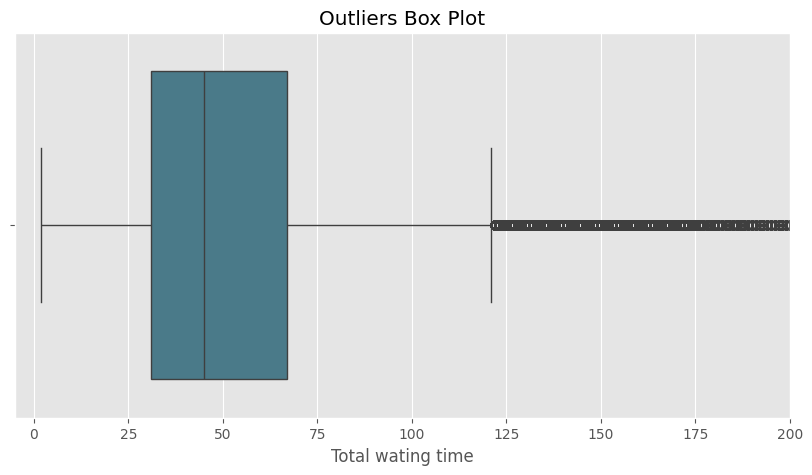

In [84]:
plt.figure(figsize=(10, 5))

# Create a box plot
g = sns.boxplot(data=df_absolut_values, x='tiempo_total', color='#3f7f93')
plt.xlim(-5, 200)

# Add a title and change xlabel
g.set_title('Outliers Box Plot')
g.set_xlabel('Total wating time')

##### Standardize the value of the age

In [12]:
df_cleaning_edad = df_without_outliers.copy()
df_cleaning_edad.rename(columns={'Edad1': 'edad_unidad'}, inplace=True)
# convert column edad_unidad to numeric.
df_cleaning_edad['edad_unidad'] = df_cleaning_edad['edad_unidad'].replace({'Años': 1, 'Meses': 1/12, 'Dias': 1/365})
# standardize the value of the age
df_cleaning_edad['edad'] = df_cleaning_edad['edad'] * df_cleaning_edad['edad_unidad']

<ipython-input-12-e0b8b0cffb15>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaning_edad['edad_unidad'] = df_cleaning_edad['edad_unidad'].replace({'Años': 1, 'Meses': 1/12, 'Dias': 1/365})


##### Outliers for 'edad' (IQR)

In [60]:
df_cleaning_edad = df_cleaning_edad.copy()
twenty_fifth = df_cleaning_edad['edad'].quantile(0.25)
seventy_fifth = df_cleaning_edad['edad'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset
outliers_edad = df_cleaning_edad[(df_cleaning_edad['edad'] < lower) | (df_cleaning_edad['edad'] > upper)]

print(f'Number of outliers:\t {len(outliers_edad)} - {len(outliers_edad) / len(df_cleaning_edad) * 100:.3f}%')

df_without_outliers_edad = df_cleaning_edad.drop(outliers_edad.index)

Number of outliers:	 3 - 0.001%


Text(0.5, 0, 'Age')

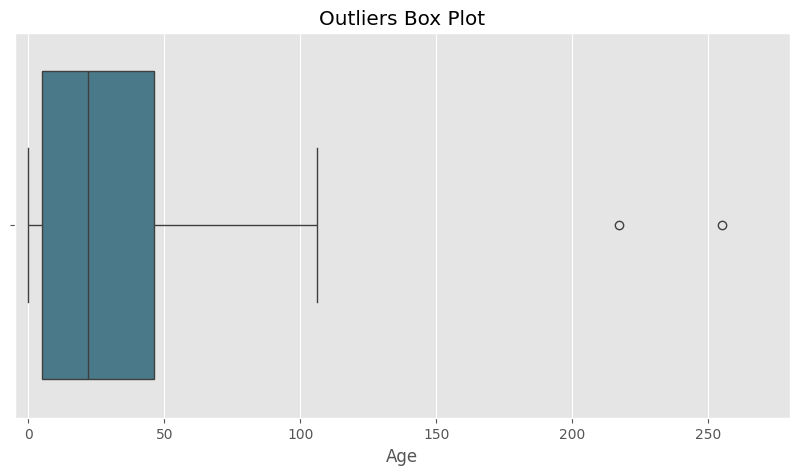

In [83]:
plt.figure(figsize=(10, 5))

# Create a box plot
g = sns.boxplot(data=df_cleaning_edad, x='edad', color='#3f7f93')
plt.xlim(-5, 280)

# Add a title and change xlabel
g.set_title('Outliers Box Plot')
g.set_xlabel('Age')

##### Obtain gender

In [15]:
!pip install gender_guesser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 10.2 MB/s eta 0:00:00


In [16]:
df_gender_detector = df_without_outliers_edad.copy()
import gender_guesser.detector as gender

# Create an gender detector object
d = gender.Detector()

def obtener_genero(nombre):
    # setting the second name, there is a total categorization between 'Ambiguo' y 'Desconocido' of 34,535 names
    nombre = nombre.split()[-1]
    nombre = nombre.title()
    # if the name is 'Femenino' or 'Masculino' return the name
    # total categorization between 'Ambiguo' y 'Desconocido' of 27,709 names. Recover 6,826 names
    if nombre == 'Femenino' or nombre == 'Masculino':
        return nombre
    else:
        return d.get_gender(nombre)

df_gender_detector['genero'] = df_gender_detector['nombre'].apply(obtener_genero)

df_gender_detector['genero'] = df_gender_detector['genero'].replace({
    'male': 'Masculino',
    'female': 'Femenino',
    'andy': 'Ambiguo',
    'unknown': 'Desconocido',
    'mostly_male': 'Masculino',
    'mostly_female': 'Femenino'
})

##### Remove 'Ambiguio' and 'Desconocido' values

In [63]:
df_gender_detector_ambiguo = df_gender_detector[(df_gender_detector['genero'] == 'Ambiguo') | (df_gender_detector['genero'] == 'Desconocido')]

print(f'Number of unknown:\t {len(df_gender_detector_ambiguo)} - {len(df_gender_detector_ambiguo) / len(df_gender_detector) * 100:.1f}%')

df_gender_detector_clean = df_gender_detector.drop(df_gender_detector_ambiguo.index)

Number of unknown:	 25817 - 10.7%


##### Encode gender and clasification

In [18]:
from sklearn.preprocessing import OneHotEncoder

# Encode calsification of triage
df_encode = df_gender_detector_clean.copy()
# Encode clasification 'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2
df_encode['clasificacion_encode'] = df_encode['clasificacion'].replace({'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2})

encoder = OneHotEncoder(sparse_output=False)
# Aplicar el codificador a la columna 'genero'
genero_encoded = encoder.fit_transform(df_encode[['genero']])
# Convertir la salida a un DataFrame
genero_encoded_df = pd.DataFrame(genero_encoded, columns=encoder.get_feature_names_out(['genero']), index=df_encode.index)
# Concatenar las columnas codificadas con el DataFrame original
df_encode = pd.concat([df_encode, genero_encoded_df], axis=1)

<ipython-input-18-31b45b874808>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encode['clasificacion_encode'] = df_encode['clasificacion'].replace({'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2})


##### Caracteristics from Date

In [19]:
df_date = df_encode.copy()
# Extract caracteristics from date
df_date['hora'] = df_date['Fecha'].dt.hour
df_date['minuto'] = df_date['Fecha'].dt.minute
df_date['mes'] = df_date['Fecha'].dt.month
df_date['dia'] = df_date['Fecha'].dt.day
df_date['dia_semana'] = df_date['Fecha'].dt.dayofweek

##### Correlation

Text(0, 0.5, 'clasificacion_encode')

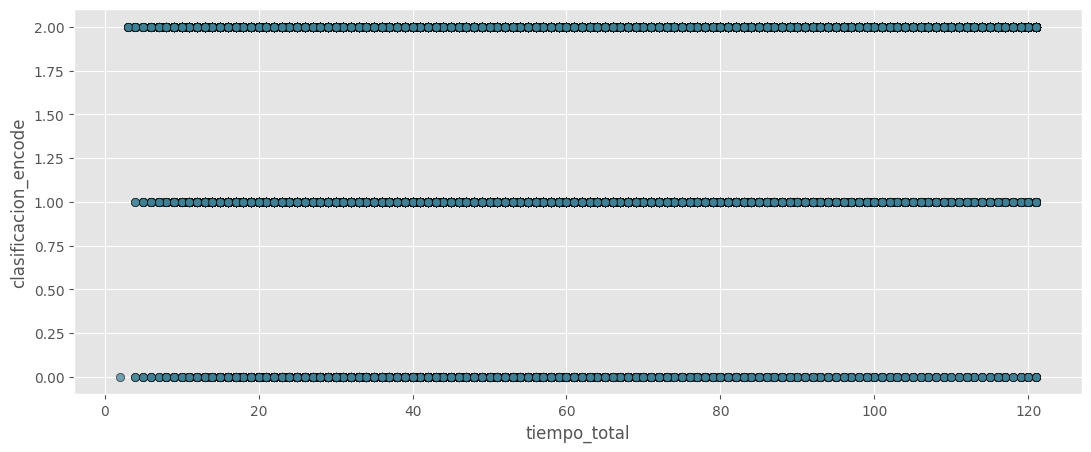

In [86]:
df_corr_graph = df_date.copy()
fig, ax = plt.subplots(1, 1, figsize=(13,5))
ax.scatter(x=df_corr_graph['tiempo_total'], y=df_corr_graph['clasificacion_encode'], alpha=0.7, color='#3f7f93', edgecolor='k')
ax.set_xlabel('tiempo_total')
ax.set_ylabel('clasificacion_encode')

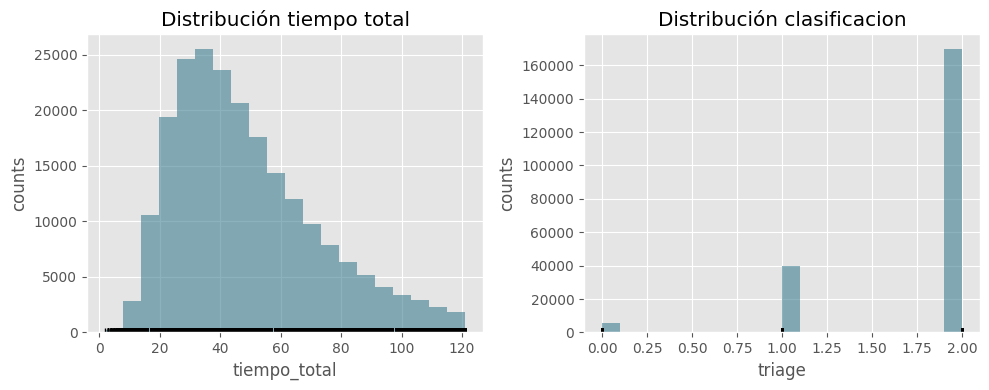

In [81]:
# histogram
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(x=df_corr_graph['tiempo_total'], bins=20, color="#3f7f93", alpha=0.6)
axs[0].plot(df_corr_graph['tiempo_total'], np.full_like(df_corr_graph['tiempo_total'], -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución tiempo total')
axs[0].set_xlabel('tiempo_total')
axs[0].set_ylabel('counts')

axs[1].hist(x=df_corr_graph['clasificacion_encode'], bins=20, color="#3f7f93", alpha=0.6)
axs[1].plot(df_corr_graph['clasificacion_encode'], np.full_like(df_corr_graph['clasificacion_encode'], -0.01), '|k', markeredgewidth=1)
axs[1].set_title('Distribución clasificacion')
axs[1].set_xlabel('triage')
axs[1].set_ylabel('counts')


plt.tight_layout();

In [87]:
df_corr = df_date.copy()
df_corr.drop(columns=['nombre', 'apat', 'amat', 'Fecha', 'Dx', 'edad_unidad', 'genero', 'clasificacion', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta'], inplace=True)
corr = df_corr.corr(method='spearman')

In [41]:
r, p = stats.pearsonr(df_corr['clasificacion_encode'], df_corr['tiempo_total'])
print(f"Correlación Pearson: r={r}, p-value={p}")

r, p = stats.spearmanr(df_corr['clasificacion_encode'], df_corr['tiempo_total'])
print(f"Correlación Spearman: r={r}, p-value={p}")

r, p = stats.kendalltau(df_corr['clasificacion_encode'], df_corr['tiempo_total'])
print(f"Correlación Pearson: r={r}, p-value={p}")

Correlación Pearson: r=0.0788543319531067, p-value=7.8918167265564e-294
Correlación Spearman: r=0.08645255220012005, p-value=0.0
Correlación Pearson: r=0.0703191994468222, p-value=0.0


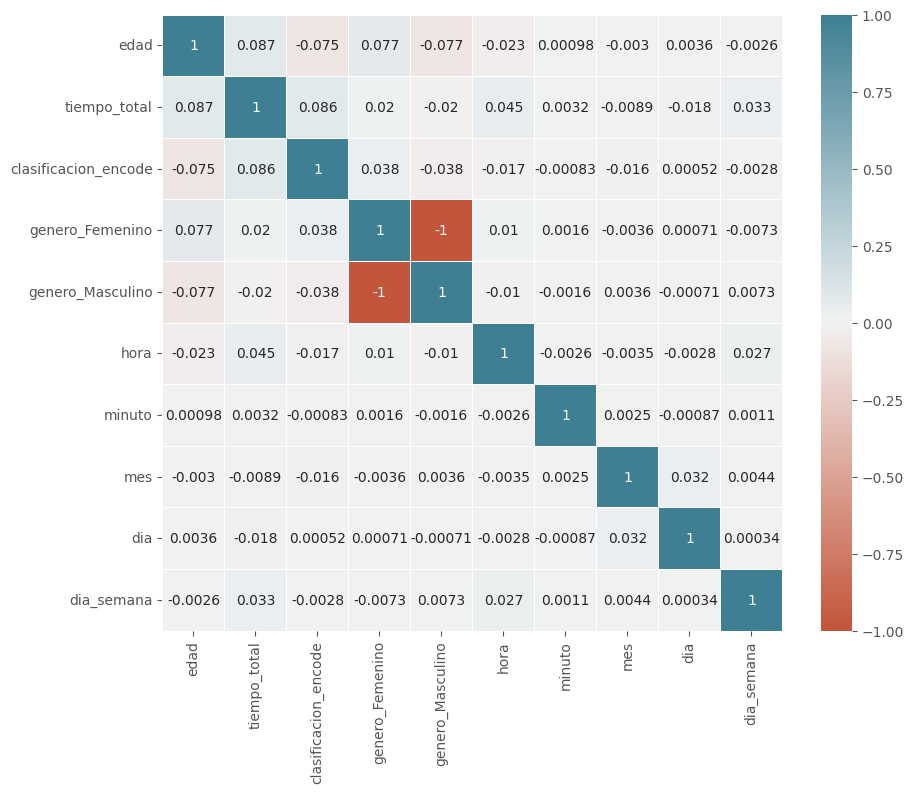

In [88]:
# Crear el mapa de calor
plt.figure(figsize=(10, 8))  # Definir el tamaño de la figura
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(20, 220, n=200), linewidths=0.5)

# Mostrar el gráfico
plt.show()

##### Removal of Punctuations

In [65]:
df_clean_text = df_date.copy()

In [71]:
import string

# clean text
df_not_string = df_clean_text[~df_clean_text['Dx'].apply(lambda x: isinstance(x, str))]
print(f'Number of not string values:\t {len(df_not_string)} - {len(df_not_string) / len(df_clean_text) * 100:.1f}%')
df_clean_text = df_clean_text.drop(df_not_string.index)

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', string.punctuation + '1' + '2' + '3'))

df_clean_text['Dx'] = df_clean_text['Dx'].apply(lambda text: remove_punctuation(text))

Number of not string values:	 0 - 0.0%


##### Remove empty string

In [78]:
df_empty_string = df_clean_text[df_clean_text['Dx'] == '']
print(f'Number of empty string:\t {len(df_empty_string)} - {len(df_empty_string) / len(df_clean_text) * 100:.1f}%')

df_without_empty_str = df_clean_text.drop(df_empty_string.index)

Number of empty string:	 1171 - 0.5%


##### Lower casing

In [74]:
df_lower_casing = df_without_empty_str.copy()
df_lower_casing['Dx'] = df_lower_casing['Dx'].str.lower()

##### Delete meaningless strings

In [77]:
import re

meaningless_strings = df_lower_casing.copy()

def search_meaningless_str(text):
    found = re.search("^x+$", text)
    if found is not None:
        return True
    else:
        return False

df_x_strings = meaningless_strings[meaningless_strings['Dx'].apply(search_meaningless_str)]
print(f'Number of meaningless string:\t {len(df_x_strings)} - {len(df_x_strings) / len(meaningless_strings) * 100:.1f}%')

df_deleted_meaningless = meaningless_strings.drop(df_x_strings.index)


Number of meaningless string:	 274 - 0.1%


##### Embeddings

In [ ]:
df_regresion = df_without_empty_str.copy()

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Create a TaggedDocument object
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df_regresion['Dx'])]

# Create a Doc2Vec model
model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=40)

df_regresion['doc2vec'] = [model.dv[str(i)] for i in range(len(tagged_data))]


In [ ]:
df_doc2vec = pd.DataFrame(df_regresion['doc2vec'].tolist(), index=df_regresion.index)
X_doc2vec = pd.concat([df_regresion.drop('doc2vec', axis=1), df_doc2vec], axis=1)
X_doc2vec.drop(columns=['nombre', 'apat', 'amat', 'Fecha', 'Dx', 'edad_unidad', 'genero', 'clasificacion', 'tiempo_total'], inplace=True)
# 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta',

In [ ]:
# convert X_doc2vec to csv file
X_doc2vec.to_csv('./evaluation_feature.csv', index=False)
df_regresion['tiempo_total'].to_csv('./target.csv', index=False)

In [ ]:
X_doc2vec.head()

,edad,clasificacion_encode,genero_Femenino,genero_Masculino,hora,minuto,mes,dia,dia_semana,0,...,90,91,92,93,94,95,96,97,98,99
0,42.0,1,0.0,1.0,8,46,8,16,0,-0.088107,...,-0.283992,0.075685,0.060538,0.284567,0.128691,-0.013482,0.184059,-0.047906,-0.031753,-0.178103
1,45.0,1,1.0,0.0,9,0,8,16,0,0.061355,...,-0.095451,0.196688,0.037411,-0.009080,0.141159,0.246847,-0.061491,-0.172121,0.133039,0.004996
7,33.0,1,1.0,0.0,9,44,8,16,0,-0.123947,...,-0.100632,-0.198273,-0.443305,0.188409,-0.225076,-0.232133,-0.274741,-0.035126,-0.076651,0.298023
9,4.0,1,0.0,1.0,9,59,8,16,0,0.081780,...,0.004751,-0.070866,-0.146901,-0.075094,-0.059237,0.084469,0.058776,0.044242,0.023129,0.006029
10,48.0,1,1.0,0.0,11,13,8,16,0,0.004022,...,0.004578,0.023451,0.009109,0.006576,0.062764,0.043072,-0.011790,-0.010112,-0.019141,0.026250


# Regression Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Select target and features
X = pd.read_csv('./prediction_feature.csv')
y = pd.read_csv('./target.csv')
y = y.values.ravel()

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Root Mean Squared Error (RMSE): 2.665875042253212
Mean Squared Error (MSE): 7.106889740908563
Coeficiente de determinación (R^2): 0.9875161795099878
Mean Absolute Error (MAE): 1.7731846171720693
   Actual  Predicted
0    67.0       63.0
1    22.0       22.0
2    23.0       23.0
3    21.0       21.0
4    49.0       50.0
5    54.0       53.0
6    35.0       33.0
7    85.0       85.0
8    27.0       29.0
9    40.0       43.0


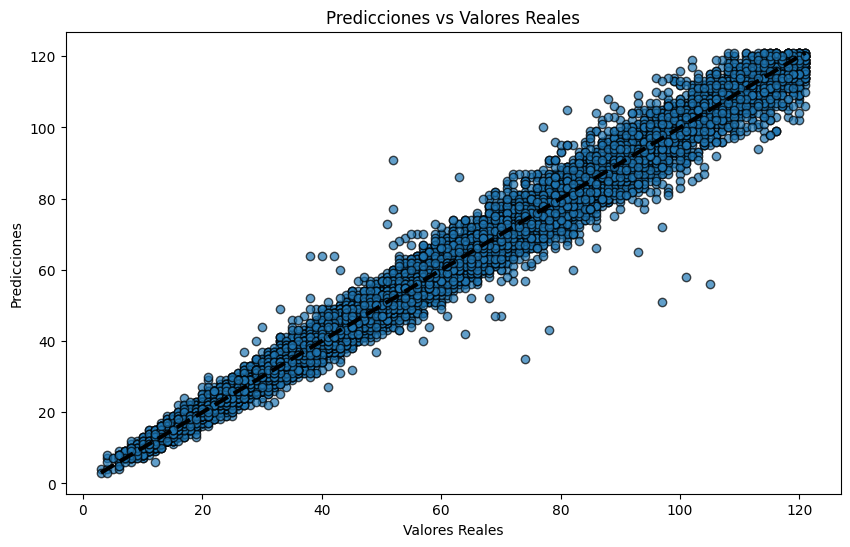

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Predictions
y_test_pred = model.predict(X_test)

# Métricas de evaluación
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_test_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolor='k', alpha=0.7, color="#3f7f93")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()


# ANN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
import datetime
import numpy as np
import pandas as pd
import os

# Select target and features
X = pd.read_csv('./prediction_feature.csv')
y = pd.read_csv('./target.csv')
y = y.values.ravel()

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.1))

  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.1))

  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.1))

  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.1))

  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.1))

  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.1))

  # model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
  # model.add(Dropout(0.1))

  model.add(Dense(1))
  return model


In [ ]:
# Check if TPU is available
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # No need to specify TPU address if on Colab
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  print("Running on TPU")
  print("All devices: ", tf.config.list_logical_devices('TPU'))
except ValueError: # If TPU is not found, use default strategy
  strategy = tf.distribute.get_strategy()
  print("Running on CPU/GPU")

Running on TPU
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
# Free session memori
tf.keras.backend.clear_session()

# Set TensorBoard
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=21, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1) # utilizar Adam
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

with strategy.scope():
  model = create_model()
  initial_learning_rate = 0.0001
  optimizer = RMSprop(learning_rate=initial_learning_rate)
  model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

  # Fit model
  history = model.fit(
      X_train, y_train,
      validation_data=(X_test, y_test),
      epochs=200,
      batch_size=20,
      callbacks=[model_checkpoint, early_stopping, tensorboard_callback], #removed: reduce_lr
      verbose=1,
  )

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/200
8560/8560 [==============================] - ETA: 0s - loss: 601.6711 - mae: 19.3202
Epoch 1: val_loss improved from inf to 547.78522, saving model to best_model.keras
8560/8560 [==============================] - 97s 11ms/step - loss: 601.6711 - mae: 19.3202 - val_loss: 547.7852 - val_mae: 18.8001
Epoch 2/200
8559/8560 [============================>.] - ETA: 0s - loss: 555.4453 - mae: 18.7590
Epoch 2: val_loss did not improve from 547.78522
8560/8560 [==============================] - 94s 11ms/step - loss: 555.4339 - mae: 18.7590 - val_loss: 555.9291 - val_mae: 18.3835
Epoch 3/200
8556/8560 [============================>.] - ETA: 0s - loss: 551.2777 - mae: 18.6785
Epoch 3: val_loss improved from 547.78522 to 545.06543, saving model to best_model.keras
8560/8560 [==============================] - 95s 11ms/step - loss: 551.2604 - mae: 18.6779 - val_loss: 545.0654 - val_mae: 18.3993
Epoch

In [ ]:
%tensorboard --logdir logs/fit

1338/1338 [==============================] - 3s 3ms/step
loss 453.0246276855469
val_loss 536.8841552734375
mae 16.722869873046875
val_mae 18.279863357543945
Root Mean Squared Error (RMSE): 23.163742534833176
Mean Squared Error (MSE): 536.5589682200397
Coeficiente de determinación (R^2): 0.049977037625320575
Mean Absolute Error (MAE): 18.29350840911687
   Actual  Predicted
0    50.0  48.003246
1    48.0  39.547626
2    38.0  46.336479
3    87.0  49.266254
4    72.0  53.370609
5    74.0  47.716068
6    62.0  56.173286
7    62.0  50.922523
8    35.0  44.710545
9    28.0  33.781471


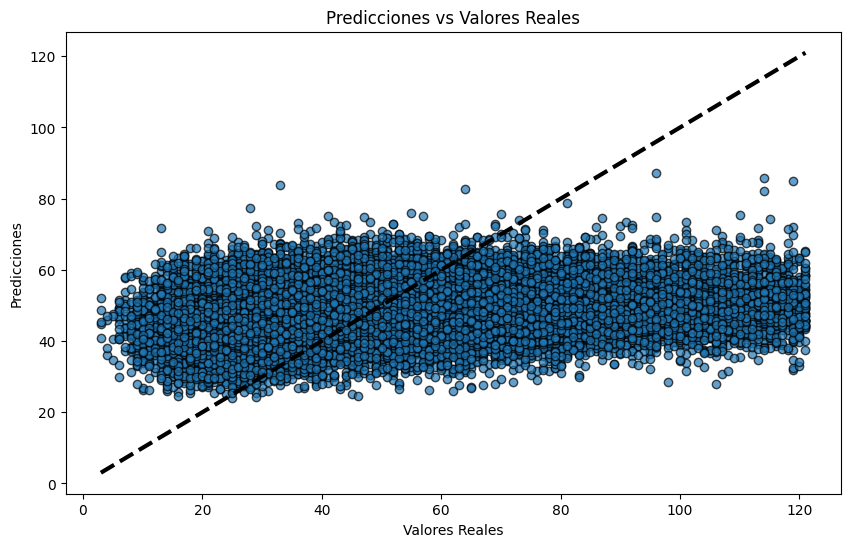

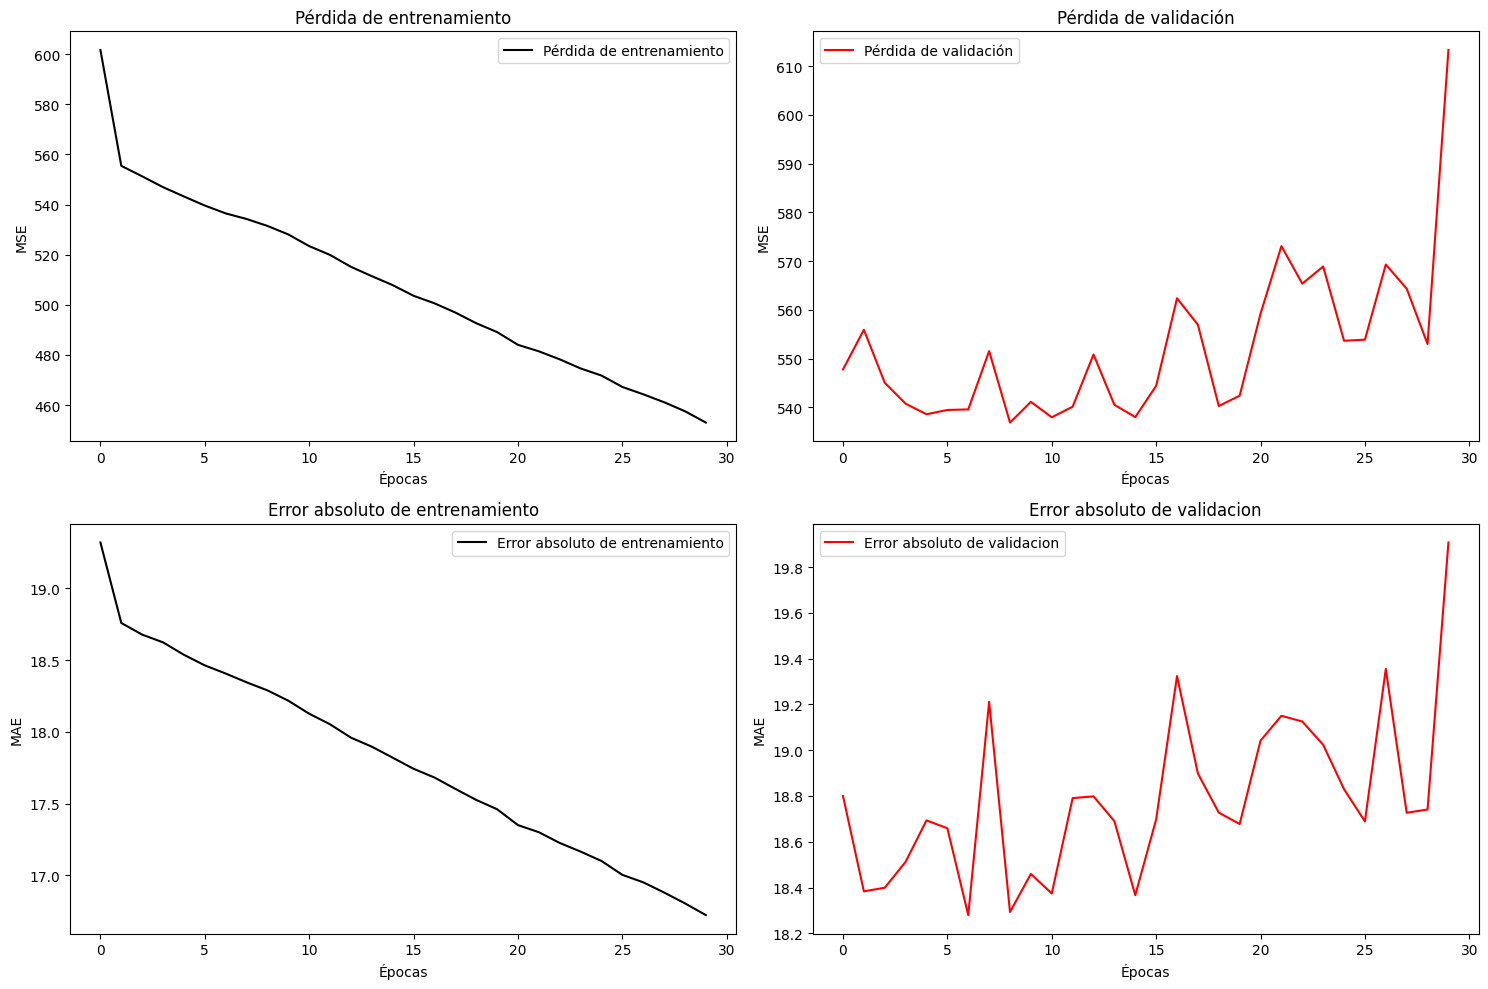

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import load_model

# Load best model
best_model = load_model("best_model.keras")

# Predicción
y_pred = best_model.predict(X_test)

# Imprimir las claves de history.history
print(f"loss {min(history.history['loss'])}")
print(f"val_loss {min(history.history['val_loss'])}")
print(f"mae {min(history.history['mae'])}")
print(f"val_mae {min(history.history['val_mae'])}")

# Métricas de evaluación
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color="#3f7f93")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Graficar la pérdida de entrenamiento
axs[0, 0].plot(history.history['loss'], label='Pérdida de entrenamiento', color="black")
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].set_title('Pérdida de entrenamiento')
axs[0, 0].legend()

# Graficar la pérdida de validación
axs[0, 1].plot(history.history['val_loss'], label='Pérdida de validación',color="red")
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].set_title('Pérdida de validación')
axs[0, 1].legend()

# Graficar MAE de entrenamiento
axs[1, 0].plot(history.history['mae'], label='Error absoluto de entrenamiento', color="black")
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_title('Error absoluto de entrenamiento')
axs[1, 0].legend()

# Graficar MAE de validación
axs[1, 1].plot(history.history['val_mae'], label='Error absoluto de validacion', color="red")
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].set_title('Error absoluto de validacion')
axs[1, 1].legend()

# Ajustar diseño para evitar solapamiento
plt.tight_layout()
plt.show()

# Analisys

##### Prepare data

In [ ]:
import plotly.express as px

In [ ]:
df_analisys = df_encode.copy()

In [ ]:
df_analisys.rename(columns={'Fecha':'date'}, inplace=True)

df_analisys['entry_time'] = df_analisys['date'].dt.time
df_analisys['entry_time'] = pd.to_timedelta(df_analisys.entry_time.astype(str))


df_analisys.rename(columns={'tiempo_total':'waiting_time'}, inplace=True)
df_analisys['waiting_time'] = pd.to_timedelta(df_analisys['waiting_time'], unit='m')

df_analisys['completion_time'] = df_analisys['waiting_time'] + df_analisys['entry_time']

df_analisys['waiting_ber_munets'] = df_analisys.waiting_time.dt.seconds / 60
df_analisys['waiting_ber_munets'] = df_analisys['waiting_ber_munets'].round(0)

df_analisys['weekday'] = df_analisys.date.dt.strftime('%A')                      # new column for extract 'weekday' from 'date'
df_analisys['hours'] = df_analisys.entry_time.dt.components.hours                # new column for extract the  'hours' from 'entry_time'

In [ ]:
df_analisys.dtypes

In [ ]:
df_analisys.drop(columns=['nombre', 'genero', 'Dx'], inplace=True)
df_analisys.head(2)

##### Patient heatmap

In [ ]:

def grouped_data2(column_name):
    if column_name == 'completion_time':
        answer = pd.pivot_table(df_analisys, index='hours', columns=['weekday'], aggfunc='count')
    elif column_name == 'waiting_ber_munets':
        answer = pd.pivot_table(df_analisys, index='hours',
                                columns=['weekday'] , aggfunc='mean').round(1)
    else:
        return(column_name + " is not in the columns")

    answer = answer[column_name]
    answer = answer.fillna(0)
    answer = answer[['Sunday', 'Monday', 'Tuesday',
                  'Wednesday', 'Thursday',
                  'Friday', 'Saturday']]
    return answer
answer3 =  grouped_data2('completion_time')
answer4 =  grouped_data2('waiting_ber_munets')
print(answer3,answer4)

In [ ]:
fig3 = px.imshow(answer3,
                labels=dict(x="weekday", y="hours", color="number of paitant") ,
                aspect="auto", color_continuous_scale='tempo',
                template = template_style,
                text_auto=True, width=900, height=900)
fig3.update_xaxes(side="top")
fig3.show()

##### Hour heatmap

In [ ]:
fig4 = px.imshow(answer4,
                labels=dict(x="weekday", y="hours",
                            color="the waiting time per min") ,
                            aspect="auto", color_continuous_scale='tempo',
                            template = template_style,
                            text_auto=True, width=900, height=900)
fig4.update_xaxes(side="top")
fig4.show()

##### Bar chart

In [ ]:
def grouped_data(column_name):
    '''
    Groupby column and return DataFrame
    Input: Column Name
    '''
    df_tmp = df_analisys.groupby(column_name)[['waiting_ber_munets']].mean().round(0)
    df_tmp2 = df_analisys[column_name].value_counts()      #this for concat

    pivot_f = pd.concat([df_tmp, df_tmp2.rename('number_of_patient')],axis=1)
    pivot_f.reset_index(inplace=True)
    pivot_f = pivot_f.rename(columns={'index': column_name })
    return pivot_f

answer5 = grouped_data('hours')
link_size = [3,6]
fig = px.bar(x=answer5['hours'],
             y=answer5['waiting_ber_munets'],
             template= template_style,
             text_auto='.2s',
             labels={'x':'the hour',
                     'y':'the waiting time per m'}
             ).add_traces(
      px.line(answer5, x=answer5['hours'], text='number_of_patient',
             y=answer5['number_of_patient'],markers=True).update_traces(yaxis="y2",
             showlegend=True, line=dict(color = 'red', width=link_size[1]), name="number_of_patient").data)
fig.update_layout(yaxis2={"side":"right", "overlaying":"y"})
fig.show()

##### Weekly chart

In [ ]:
answer2 =  grouped_data('weekday')
# Create Chart for the Daily
fig2 = px.bar(answer2,
             x='weekday',
             y='number_of_patient',
             color='waiting_ber_munets',
             labels={'waiting_ber_munets':'the waiting time per m'} ,
             color_continuous_scale=['green','yellow','red'],
             template = template_style,
             title = '<b>Daily visualization</b>')
# Display Plot
fig2.show()

# Results